# NIFTY: A NON-LOCAL IMAGE FLOW MATCHING FOR TEXTURE SYNTHESIS


In [6]:
from Nifty.method import *
from Nifty.networks import *
import warnings; warnings.filterwarnings('ignore')

## Basic use:
rs:    Ratio of the reference patches to sample at each step.\
T:     Number of (linear) distretization steps between 0 and 1 to solve the flow ODE.\
k: Number of top closest patrch used to approximate the velocity field.\
octaves:   Number of diadic scales used for the synthesis\
renoise: 'time' $t_r$ used renoise the smooth upsampled image at each resolution: $x_{start}=t_r*x_{upsampled}+(1-t_r)z$. In particular, $t_r=1$ means  additional noise.\

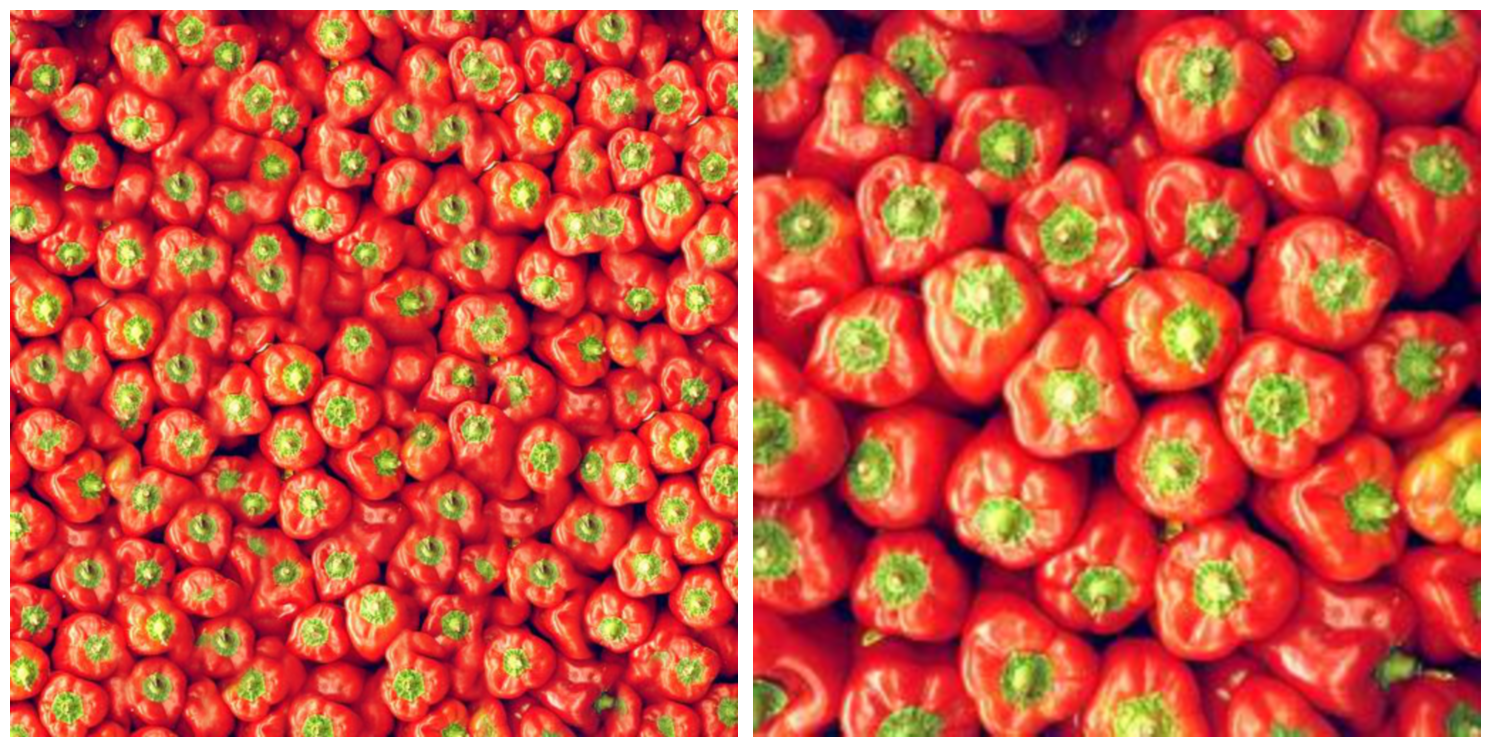

Elapsed time : 4.34 s


In [7]:
img = Tensor_load('results/red_peppers.jpg')[...]
t0 = time.time()
synth= Nifty(img,rs=1,T=50,k=5,patchsize=16,stride=4,octaves=3,size=(512,512),renoise=0.5,warmup=0,memory=True,show=True)
t0 = time.time()-t0      
print('Elapsed time : %.2f s'%t0)


In [3]:
imsize = 256 # 128 # 256 # 512 : desired input/output resolution
imsize_out = 256 
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

data_rep = 'textures/'
im_name  =   'red_peppers_256.jpg' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
#im_name= 'pumkins_512.png'
save_rep = 'res/'


file_name = data_rep + im_name
 
## load image as a Tensor
img_torch = Tensor_load(file_name)[...]#,:64,:64]
#img_torch = F.interpolate(img_torch, size=(imsize, imsize), mode='bicubic') # resize to desired size
img_torch0 = torch.clone(img_torch)*2-1


patchsize=16
stride=16

P_exmpl = Patch_extraction(img_torch0,patchsize=patchsize,stride=stride) 

lrs=[.1,.5,1]
lk=[1,3,5,10,20,30,40,50,100,256]
base=4
plt.figure(figsize=(base*16/9,base))
for rs in tqdm(lrs):
    for memory in [0,1]:
        l=[]
        for k in lk:
            try:
                cost=0
                n_run=5
                for seed in range(n_run):
                    synth= Diffusion(img_torch0,rs=rs,T=50,k=k,patchsize=patchsize,stride=stride,octaves=1,size=(512,512),renoise=0.5,show=False,memory=memory,warmup=0,seed=seed) 
                    P_synth = Patch_extraction(synth,patchsize, stride)
                    D=(P_exmpl[0]**2).sum(0,keepdim=True).T-2*P_exmpl[0].T@P_synth[0]+(P_synth[0]**2).sum(0,keepdim=True)
                    a = torch.ones(P_exmpl.shape[-1]).cuda() / P_exmpl.shape[-1]  # uniform distribution over patches
                    b = torch.ones(P_synth.shape[-1]).cuda() / P_synth.shape[-1]  # uniform distribution over patches
                    P = ot.emd(a, b, D)  # exact OT plan
                    cost+=torch.sqrt(torch.sum(P * D)/P_synth.shape[-1]).cpu().numpy()
                l.append(cost/n_run)
            except:
                print(rs,k)
        plt.plot(np.array(lk[:len(l)])/P_exmpl.shape[-1],l,label='%d%% data%s'%(100*rs,', w/ memory' if memory else ' w/o memory'),linestyle='--' if memory else '-',color=(rs,0,1-rs))
    
plt.xlabel('Fraction $\\frac{k}{N}$ corresponding to selection of top $k$ out of $N$ patches',fontsize=12)
plt.ylabel('$\mathcal{W}_2$ distance',fontsize=16)
plt.title('$\mathcal{W}_2$ distance vs k (%d synhtesis vs %d examples)'%(P_synth.shape[-1],P_exmpl.shape[-1]),fontsize=14)
plt.legend(loc='best',fontsize=14)
plt.grid()
plt.savefig('./results/rs_k_memory.pdf',bbox_inches='tight')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'textures/red_peppers_256.jpg'

Patch pixel blending

In [ ]:
imsize = 256 # 128 # 256 # 512 : desired input/output resolution
imsize_out = 256 
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

data_rep = 'textures/'
! ls textures/
im_name  =   'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png

save_rep = 'res/'


file_name = data_rep + 'red_peppers_256.jpg' # 'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
file_name2 = data_rep + 'cordes.png'# 'radishes_256.jpg' # 'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
 
## load image as a Tensor
img_torch = Tensor_load(file_name)[...]#,:64,:64]
#img_torch = F.interpolate(img_torch, size=(imsize, imsize), mode='bicubic') # resize to desired size
print(img_torch.shape)
im1 = Tensor_load(file_name)[...]*2-1
im2 = Tensor_load(file_name2)[...]*2-1

blend_alpha=.6
synth= Diffusion(im1,im2,rs=1.,T=50,k=10,patchsize=16,stride=4,octaves=3,size=(256,256),renoise=0.3,warmup=0,memory=True,blend=True,blend_alpha=blend_alpha,show=False) 
imsave('interp_pixel_space_%s_%s_%.1f'%(file_name.split('.')[0].split('/')[-1],file_name2.split('.')[0].split('/')[-1],blend_alpha),synth)


cordes.png	   fabric.jpg  pumkins_512.png	 rafia.jpg	      tiles.png
_DSC0418_2048.jpg  paper.jpg   radishes_256.jpg  red_peppers_256.jpg
torch.Size([1, 3, 256, 256])


Patch distribution blending

In [ ]:
imsize = 256 # 128 # 256 # 512 : desired input/output resolution
imsize_out = 256 
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

data_rep = 'textures/'
! ls textures/
im_name  =   'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png

save_rep = 'res/'


file_name = data_rep + 'red_peppers_256.jpg' # 'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
file_name2 = data_rep + 'cordes.png'#'radishes_256.jpg' # 'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
 
## load image as a Tensor
img_torch = Tensor_load(file_name)[...]#,:64,:64]
#img_torch = F.interpolate(img_torch, size=(imsize, imsize), mode='bicubic') # resize to desired size
print(img_torch.shape)
im1 = Tensor_load(file_name)[...]*2-1
im2 = Tensor_load(file_name2)[...]*2-1

synth= Diffusion(im1,im2,rs=1.,T=50,k=10,patchsize=16,stride=4,octaves=3,size=(256,256),renoise=0.5,warmup=0,memory=True,show=False) 
imsave('interp_patch_distribution_%s_%s'%(file_name.split('.')[0].split('/')[-1],file_name2.split('.')[0].split('/')[-1]),synth)


cordes.png	   fabric.jpg  pumkins_512.png	 rafia.jpg	      tiles.png
_DSC0418_2048.jpg  paper.jpg   radishes_256.jpg  red_peppers_256.jpg
torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.311708..10.649178].


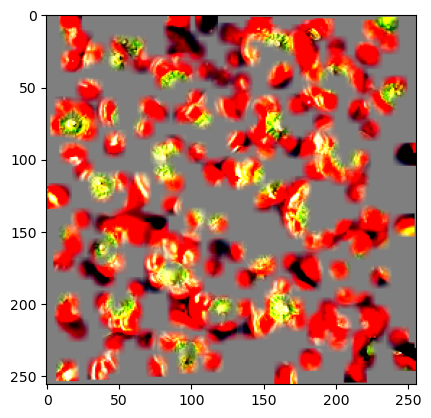

In [ ]:
# patch subsampling 
rs=.005
P_exmpl = Patch_extraction(img_torch0,patchsize=16,stride=1) # 1 x 3P^2 x HW/stride^2
N_subsampling=int(rs*P_exmpl.shape[-1])
I = torch.randperm(P_exmpl.shape[-1])#.to(device)
I = I[0:N_subsampling]
X = P_exmpl[:,:,I]
Y=P_exmpl*0
Y[:,:,I]=X
y=Patch_Average(Y, patchsize=16, stride=1, W=256, H=256, r=2, D=torch.ones((1, 1, N_subsampling)).cuda())
plt.imshow(y[0].permute(1, 2, 0).detach().cpu().numpy()/rs*.5+.5 )

cordes.png	   fabric.jpg  pumkins_512.png	 rafia.jpg	      tiles.png
_DSC0418_2048.jpg  paper.jpg   radishes_256.jpg  red_peppers_256.jpg


100%|██████████| 49/49 [00:02<00:00, 19.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000001].


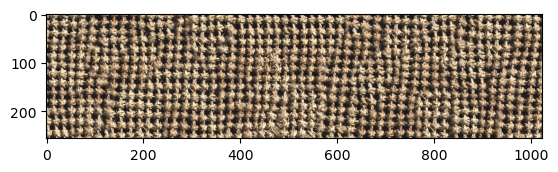

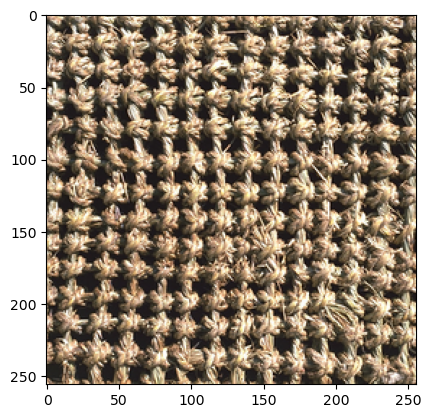

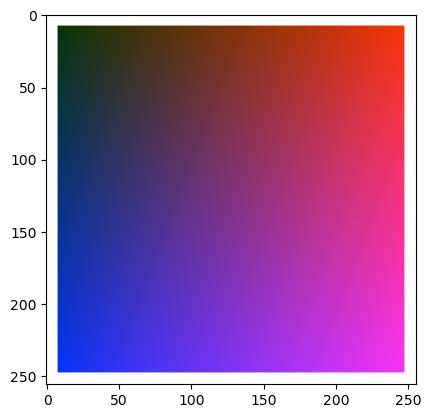

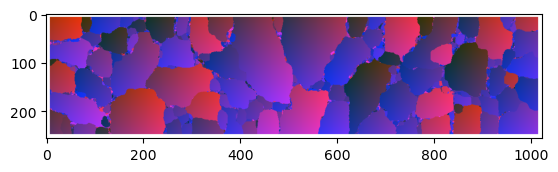

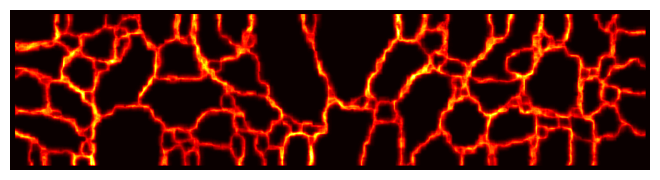

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0025336742..1.0000001].


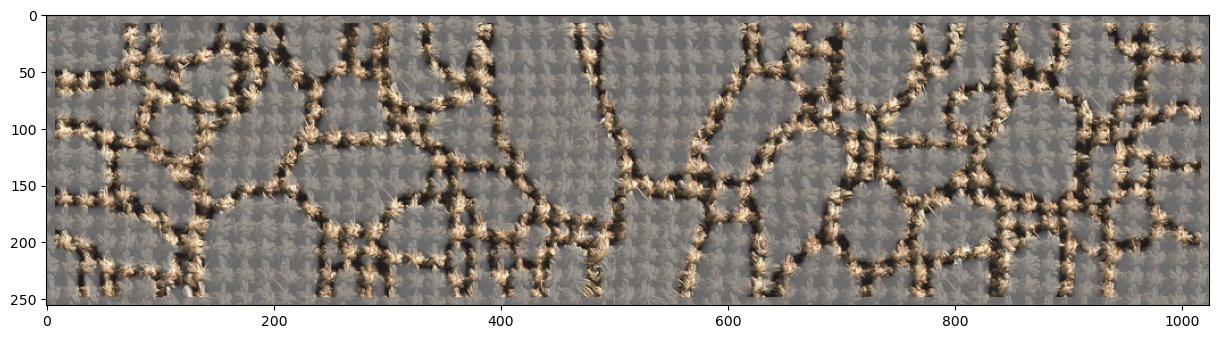

average L2 distance tensor(3.1888)


In [ ]:
torch.manual_seed(0)

imsize = 256 # 128 # 256 # 512 : desired input/output resolution
imsize_out = 256 
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

data_rep = 'textures/'
! ls textures/
im_name  =   'red_peppers_256.jpg' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
H0,W0=256,256
save_rep = 'res/'

file_name = data_rep + im_name
file_name='comp/raad_256/raad8.png'
 
## load image as a Tensor
img_torch = Tensor_load(file_name)[...]#,:64,:64]
#img_torch = F.interpolate(img_torch, size=(imsize, imsize), mode='bicubic') # resize to desired size
img_torch0 = torch.clone(img_torch)*2-1

H,W=256,1024
patchsize=16
stride=4

synth= Diffusion(img_torch0,rs=.1,T=100,k=5,patchsize=patchsize,stride=stride,octaves=3,size=(H,W),renoise=0.5,warmup=10,memory=True,show=False) 


P_exmpl = Patch_extraction(img_torch0,patchsize=patchsize,stride=1)
P_synth = Patch_extraction(synth,patchsize=patchsize,stride=1)

N = P_synth.size(2)
ld=[]
lind=[]
for i in tqdm(range(N//5000+1)):


    X = P_exmpl[:,:,:] #.to(device) # 1 x d x Ns
    X = X.squeeze(0) # d x Ns

    X2 = (X**2).sum(0).unsqueeze(0) # 1 x Ns

    Y = P_synth[:,:,5000*i:5000*(i+1)].squeeze(0) # d x N

    Y2 = (Y**2).sum(0).unsqueeze(0) # squared norm : 1 x N
    D = Y2.transpose(1,0) - 2 * torch.matmul(Y.transpose(1,0),X) + X2 #N Ns
    Dnn,indnn=torch.min(D,dim=1)
    ld.append(Dnn.cpu())
    lind.append(indnn.cpu())


Dnn=torch.cat(ld)
indnn=torch.cat(lind)

y_grid = torch.linspace(0,1,H0) 
x_grid = torch.linspace(0,1,W0)
grid_y, grid_x = torch.meshgrid(y_grid, x_grid, indexing='ij')  # H_patches x W_patches
coords = torch.stack((grid_x,.2+0.*grid_x, grid_y), dim=0)

P_color0=Patch_extraction(coords,patchsize=patchsize,stride=1)
P_color=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])*0
P_color[:,patchsize//2,patchsize//2,:]=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])[:,patchsize//2,patchsize//2,:]
P_color=P_color.reshape(3*patchsize**2,-1)
P_warp=P_color[:,indnn]
warp=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_warp)

P_dist=P_synth*0
P_dist=P_dist.view(3,patchsize,patchsize,P_dist.shape[-1])[:1]*0.
P_dist[0,patchsize//2,patchsize//2,:]=Dnn/Dnn.max()
dist=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_dist.view(patchsize**2,-1))

rec=nn.Fold((H0,W0), patchsize, dilation=1, padding=0, stride=1)(P_color)

warp[...,:patchsize//2]=1.
warp[...,-patchsize//2:]=1.
warp[...,:patchsize//2,:]=1.
warp[...,-patchsize//2:,:]=1.

rec[...,:patchsize//2]=1.
rec[...,-patchsize//2:]=1.
rec[...,:patchsize//2,:]=1.
rec[...,-patchsize//2:,:]=1.

cutoff=0.2
mask=(dist/cutoff)
mask[dist>cutoff]=1
mask=.8*mask+.2

novelty=synth*mask
novelty=synth*mask


plt.imshow(synth[0].permute(1,2,0).cpu()*.5+.5)
plt.show()
imsave('fig_synth',synth)

plt.imshow(img_torch0[0].permute(1,2,0).cpu()*.5+.5)
plt.show()
imsave('fig_ref',img_torch0)

plt.imshow(rec.cpu().permute(1,2,0))
plt.show()
imsave('fig_gt_warp',rec*2-1)

plt.imshow(warp.cpu().permute(1,2,0))
plt.show()
imsave('fig_warp',warp*2-1)

plt.imshow(dist.cpu()[0],cmap='hot')
plt.axis('off')  # Hide axes
plt.tight_layout(pad=0)  # Remove padding around image
plt.savefig('results/fig_dist.png', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(novelty[0].permute(1,2,0).cpu()*.5+.5)
plt.show()
imsave('fig_novelty',novelty)

print('average L2 distance',torch.cat((Dnn[Dnn>0]**.5,torch.tensor([0]*((Dnn<=0).sum())))).mean())



Compare with Unet approximation of the flow


# Compare Nifty approximation to U-Net approximation of the flow
A U-Net is trained to learn the velocity field.\
Starting from the same noise initialization, the flow ODE is solved in identical fashion, for both velocity approxiamtions.\
The depth of the Unet is chosen so that its receptive field is approximately the same as the patch size of Nifty.\
We discard the border areas to avoid padding artifacts.


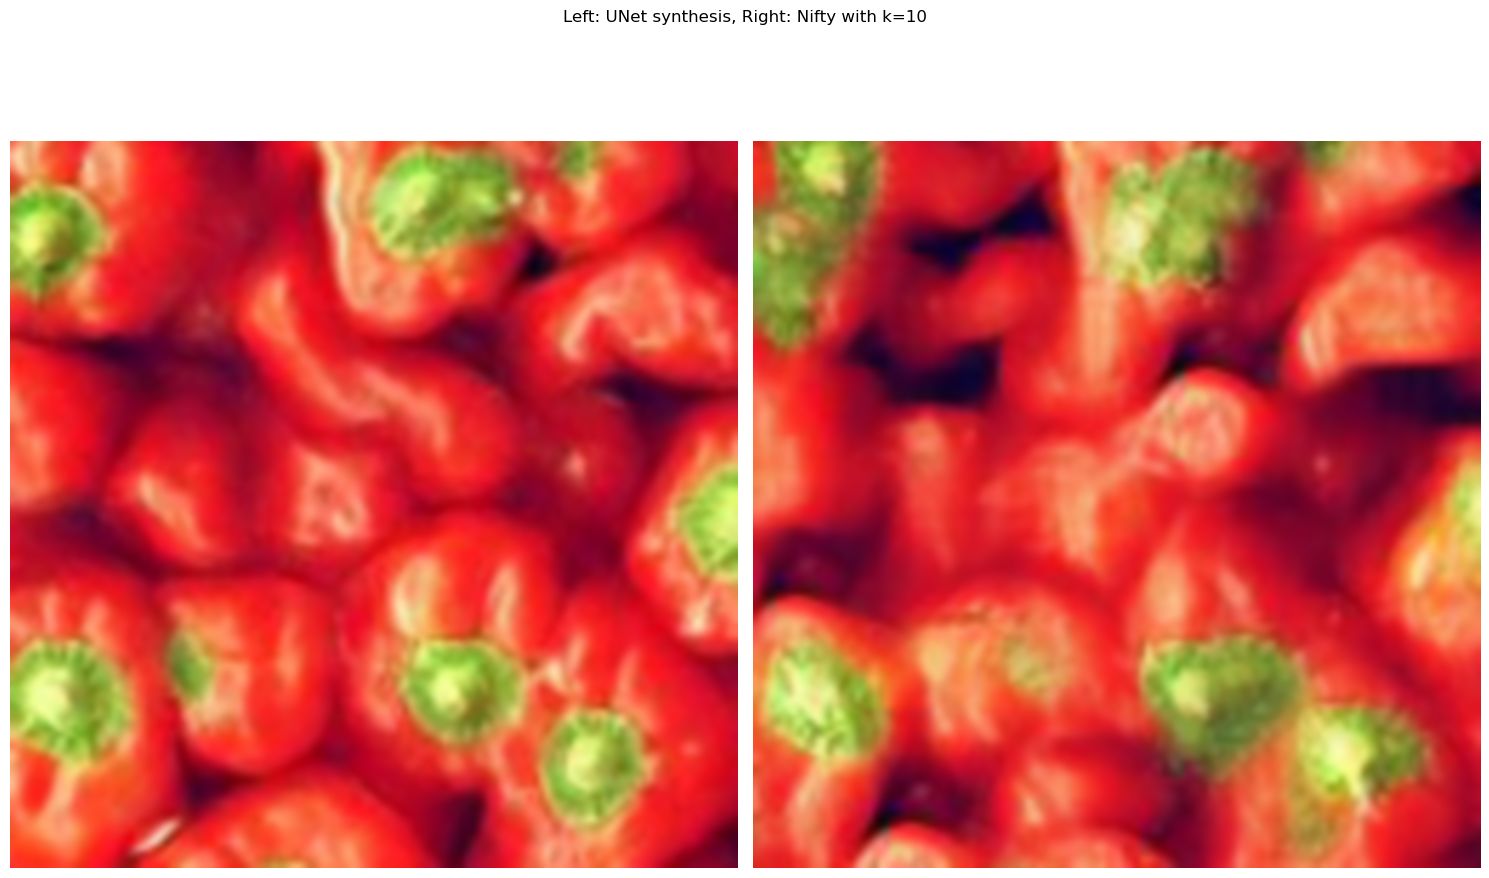

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1435.4774..90.91735].


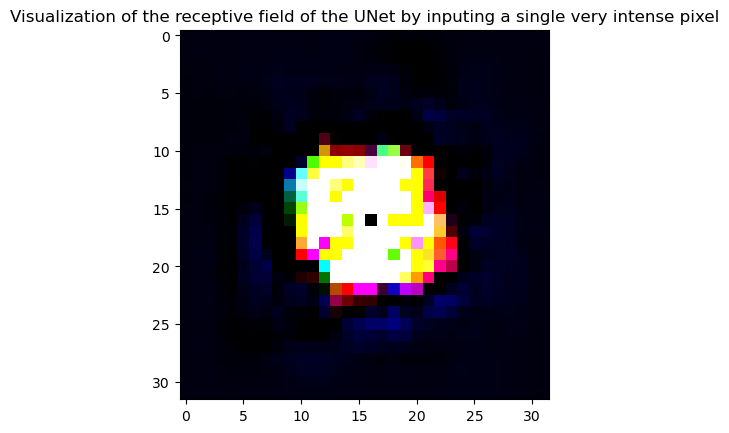

In [ ]:
from Nifty.method import *
from Nifty.networks import *
import warnings; warnings.filterwarnings('ignore')

torch.manual_seed(0)
img = Tensor_load('results/red_peppers.jpg')
mu,sigma=img.mean(),img.std()

flow_model = UNet(
        dim =64,
        dim_mults = (1, 2)).cuda()

if not os.path.exists('./results/UNet_peppers.pth'): 
    train_flow_net((img-mu)/sigma , flow_model,load=False,epochs=10000,show=False,save_name='./results/UNet_peppers.pth')

flow_model.load_state_dict(torch.load('./results/UNet_peppers.pth', map_location='cuda'))
flow_model.eval().cuda()


T=50
torch.manual_seed(0)
noise=torch.randn(1,3,256,256).cuda()
with torch.no_grad():
    x = noise*1.
    times=torch.linspace(0, 1, steps=T+1).cuda()
    for it in range(T):
        t=times[it]
        t = t.to(device).unsqueeze(0)
        flow = flow_model(x,t.view(1))
        x=x+flow*(times[it+1]-times[it])

synth_nn = x*sigma+mu
synth_nn=synth_nn[...,64:64+128,64:64+128]
imsave('results/synth_nn.png',synth_nn)

lk=[10]
for k in lk:
    synth_patch=Nifty(img,rs=1,T=T,k=k,patchsize=16,stride=4,octaves=1,size=(256,256),renoise=0.5,warmup=0,memory=True,noise=noise,show=False,spotsize=1/4) 
    synth_patch=synth_patch[...,64:64+128,64:64+128]
    imsave('results/synth_patch_k_%d.png'%k,synth_patch)
    Tensor_display(synth_nn, synth_patch,s='Left: UNet synthesis, Right: Nifty with k=%d'%k)


x0=-torch.ones(1,3,64,64).cuda()
x0[:,:,32,32]=1000
plt.figure()
plt.title('Visualization of the receptive field of the UNet by inputing a single very intense pixel')
plt.imshow(flow_model(x0,torch.tensor(.5).view(1).cuda())[0,:,16:48,16:48].permute(1, 2, 0).detach().cpu().numpy())




In [ ]:
#novelty nifty vs TO

torch.manual_seed(0)

file_name='./comp/raad_256/raad1.png'
img_torch0 = Tensor_load(file_name)[...]*2-1

file_name='./comp/raad1/nifty/0.png'
synth1 = Tensor_load(file_name)[...]*2-1

file_name='./comp/raad1/kwatra_patch/0.png'
synth2 = Tensor_load(file_name)[...]*2-1

patchsize=16
H0,W0=256,256
H,W=512,512

P_exmpl = Patch_extraction(img_torch0,patchsize=patchsize,stride=1)
for synth,method in zip([synth1,synth2],['nifty','kwatra']):
    P_synth = Patch_extraction(synth,patchsize=patchsize,stride=1)

    N = P_synth.size(2)
    ld=[]
    lind=[]
    for i in tqdm(range(N//5000+1)):


        X = P_exmpl[:,:,:] #.to(device) # 1 x d x Ns
        X = X.squeeze(0) # d x Ns

        X2 = (X**2).sum(0).unsqueeze(0) # 1 x Ns

        Y = P_synth[:,:,5000*i:5000*(i+1)].squeeze(0) # d x N

        Y2 = (Y**2).sum(0).unsqueeze(0) # squared norm : 1 x N
        D = Y2.transpose(1,0) - 2 * torch.matmul(Y.transpose(1,0),X) + X2 #N Ns
        Dnn,indnn=torch.min(D,dim=1)
        ld.append(Dnn.cpu())
        lind.append(indnn.cpu())


    Dnn=torch.cat(ld)
    indnn=torch.cat(lind)

    y_grid = torch.linspace(0,1,H0) 
    x_grid = torch.linspace(0,1,W0)
    grid_y, grid_x = torch.meshgrid(y_grid, x_grid, indexing='ij')  # H_patches x W_patches
    coords = torch.stack((grid_x,.2+0.*grid_x, grid_y), dim=0)

    P_color0=Patch_extraction(coords,patchsize=patchsize,stride=1)
    P_color=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])*0
    P_color[:,patchsize//2,patchsize//2,:]=P_color0.view(3,patchsize,patchsize,P_color0.shape[-1])[:,patchsize//2,patchsize//2,:]
    P_color=P_color.reshape(3*patchsize**2,-1)
    P_warp=P_color[:,indnn]
    warp=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_warp)

    P_dist=P_synth*0
    P_dist=P_dist.view(3,patchsize,patchsize,P_dist.shape[-1])[:1]*0.
    P_dist[0,patchsize//2,patchsize//2,:]=Dnn/Dnn.max()
    dist=nn.Fold((H,W), patchsize, dilation=1, padding=0, stride=1)(P_dist.view(patchsize**2,-1))

    rec=nn.Fold((H0,W0), patchsize, dilation=1, padding=0, stride=1)(P_color)

    warp[...,:patchsize//2]=1.
    warp[...,-patchsize//2:]=1.
    warp[...,:patchsize//2,:]=1.
    warp[...,-patchsize//2:,:]=1.

    rec[...,:patchsize//2]=1.
    rec[...,-patchsize//2:]=1.
    rec[...,:patchsize//2,:]=1.
    rec[...,-patchsize//2:,:]=1.

    cutoff=0.2
    mask=(dist/cutoff)
    mask[dist>cutoff]=1
    mask=.8*mask+.2

    novelty=synth*mask
    novelty=synth*mask

    if False:
        plt.imshow(synth[0].permute(1,2,0).cpu()*.5+.5)
        plt.show()
        imsave('fig_synth',synth)

        plt.imshow(img_torch0[0].permute(1,2,0).cpu()*.5+.5)
        plt.show()
        imsave('fig_ref',img_torch0)

        plt.imshow(rec.cpu().permute(1,2,0))
        plt.show()
        imsave('fig_gt_warp',rec*2-1)

        plt.imshow(warp.cpu().permute(1,2,0))
        plt.show()
        imsave('fig_warp',warp*2-1)

        plt.imshow(dist.cpu()[0],cmap='hot')
        plt.axis('off')  # Hide axes
        plt.tight_layout(pad=0)  # Remove padding around image
        plt.savefig('results/fig_dist.png', bbox_inches='tight', pad_inches=0)
        plt.show()

    #plt.figure(figsize=(15,15))
    #plt.imshow(torchvision.transforms.CenterCrop(128)(novelty)[0].permute(1,2,0).cpu()*.5+.5)
    #plt.show()
    imsave('novelty_%s'%method,torchvision.transforms.CenterCrop(128)(novelty))

    print('average L2 distance',torch.cat((Dnn[Dnn>0]**.5,torch.tensor([0]*((Dnn<=0).sum())))).mean())
imsave('novelty_%s'%'gt',torchvision.transforms.CenterCrop(128)(img_torch0))


100%|██████████| 50/50 [00:02<00:00, 18.94it/s]


average L2 distance tensor(1.0740)


100%|██████████| 50/50 [00:02<00:00, 19.08it/s]


average L2 distance tensor(1.0499)


/tmp/ipykernel_20860/744585923.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_name+'.pth', map_location=device))
100%|██████████|

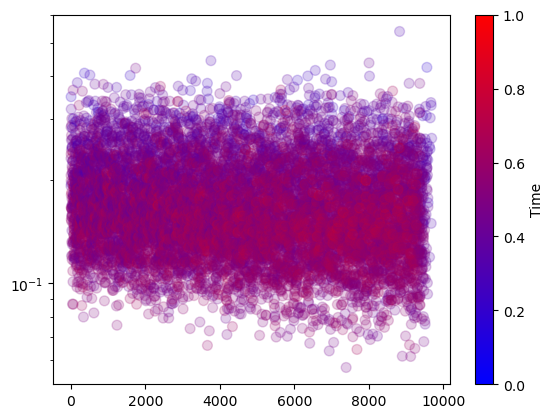

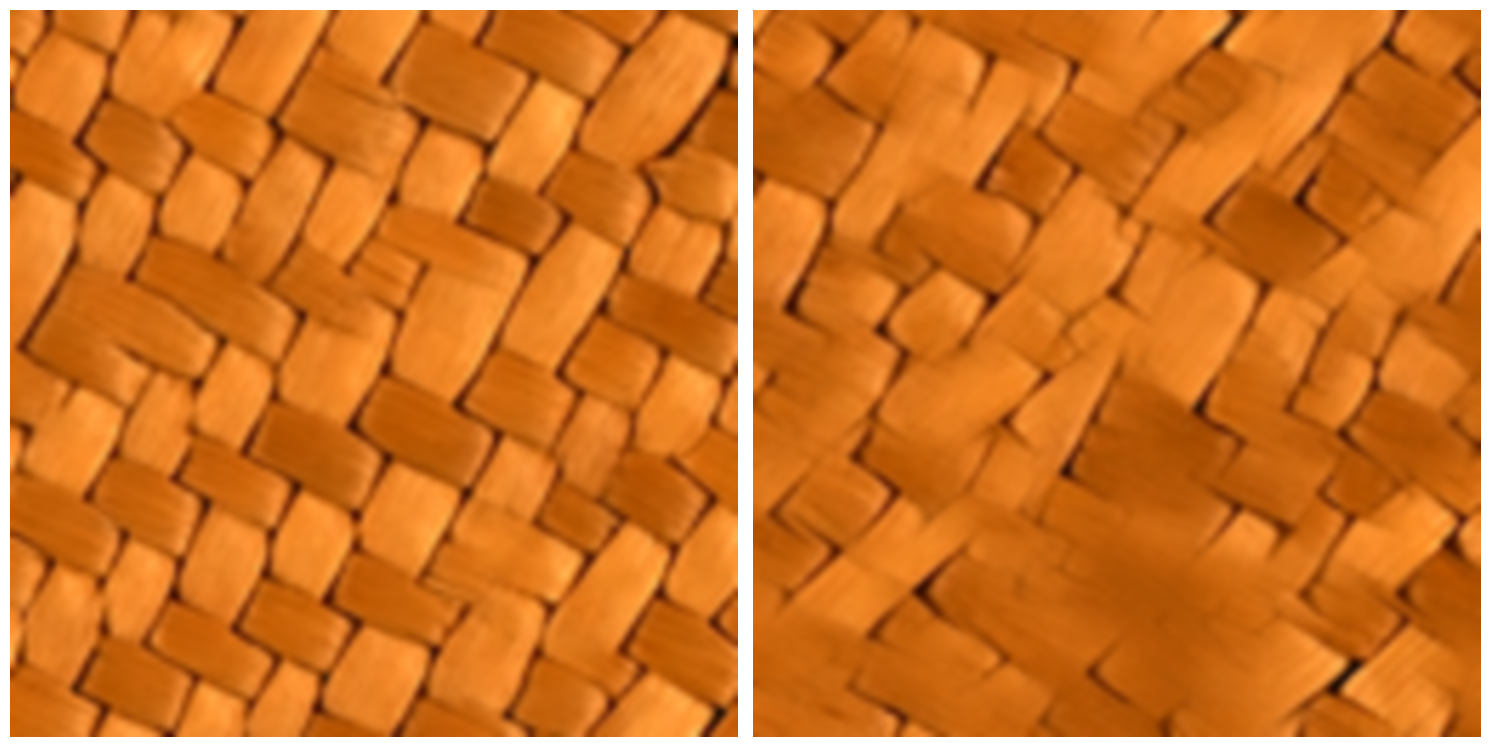

/tmp/ipykernel_20860/744585923.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow_model.load_state_dict(torch.load('raad%d.pth'%j, map_location='cuda'))
 12%|█▏      

KeyboardInterrupt: 

In [ ]:






output_size = 512
t0 = time.time()
for j in range(1,13):
    im_name='raad%d.png'%j
    path=os.path.join('./comp/raad_256/', im_name)
    img_torch = Tensor_load(path)[...]
    img_torch0 = torch.clone(img_torch)*2-1
    os.makedirs('./comp/%s/FM'%(im_name.split('.')[0]), exist_ok=True)


    mu,sigma=img_torch0.mean(),img_torch0.std()



    flow_model = Unet(
        dim =16,
        dim_mults = (1, 2, 4, 4),
        mid_fourier=False)

    #flow_model = TimeConditionedUNet(base_channels=128)

    train_flow_net((img_torch0-mu)/sigma , flow_model,load=True,epochs=10000,save_name='raad%d'%j)

    flow_model.load_state_dict(torch.load('raad%d.pth'%j, map_location='cuda'))
    flow_model.eval().cuda()


    for i in range(10):
        torch.manual_seed(i)

        T=100
        noise_nn=torch.randn(1,3,512,512).cuda()
        noise=noise_nn[...,64:64+128,64:64+128]
        with torch.no_grad():
            x = noise_nn*1.
            times=torch.linspace(0, 1, steps=T+1).cuda()
            for it in range(T):
                t=times[it]
                t = t.to(device).unsqueeze(0)
                flow = flow_model(x,t.view(1))
                x=x+flow*(times[it+1]-times[it])

        synth_nn = x*sigma+mu
        #synth_nn=synth_nn[...,64:64+128,64:64+128]
        imsave('../comp/%s/FM/%d'%(im_name.split('.')[0],i),synth_nn)
         

In [ ]:


output_size = 512
t0 = time.time()
for j in range(1,13):
    im_name='raad%d.png'%j
    path=os.path.join('./comp/raad_256/', im_name)
    img_torch = Tensor_load(path)[...]
    img_torch0 = torch.clone(img_torch)*2-1
    os.makedirs('./comp/%s/FM'%(im_name.split('.')[0]), exist_ok=True)


    mu,sigma=img_torch0.mean(),img_torch0.std()



    flow_model = Unet(
        dim =16,
        dim_mults = (1, 2, 4, 4),
        mid_fourier=False)

    #flow_model = TimeConditionedUNet(base_channels=128)

    #train_flow_net((img_torch0-mu)/sigma , flow_model,load=True,epochs=10000,save_name='raad%d'%j)

    flow_model.load_state_dict(torch.load('raad%d.pth'%j, map_location='cuda'))
    flow_model.eval().cuda()

    t0=time.time()
    for i in range(10):
        torch.manual_seed(i)
        T=15
        noise_nn=torch.randn(1,3,512,512).cuda()
        noise=noise_nn[...,64:64+128,64:64+128]
        with torch.no_grad():
            x = noise_nn*1.
            times=torch.linspace(0, 1, steps=T+1).cuda()
            for it in range(T):
                t=times[it]
                t = t.to(device).unsqueeze(0)
                flow = flow_model(x,t.view(1))
                x=x+flow*(times[it+1]-times[it])

        synth_nn = x*sigma+mu
        #synth_nn=synth_nn[...,64:64+128,64:64+128]
        imsave('../comp/%s/FM/%d'%(im_name.split('.')[0],i),synth_nn)
    print((time.time()-t0)/10)
         

FileNotFoundError: [Errno 2] No such file or directory: './comp/raad_256/raad1.png'

/tmp/ipykernel_20860/1017977767.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow_model.load_state_dict(torch.load('peppers_small_rf.pth', map_location='cuda'))


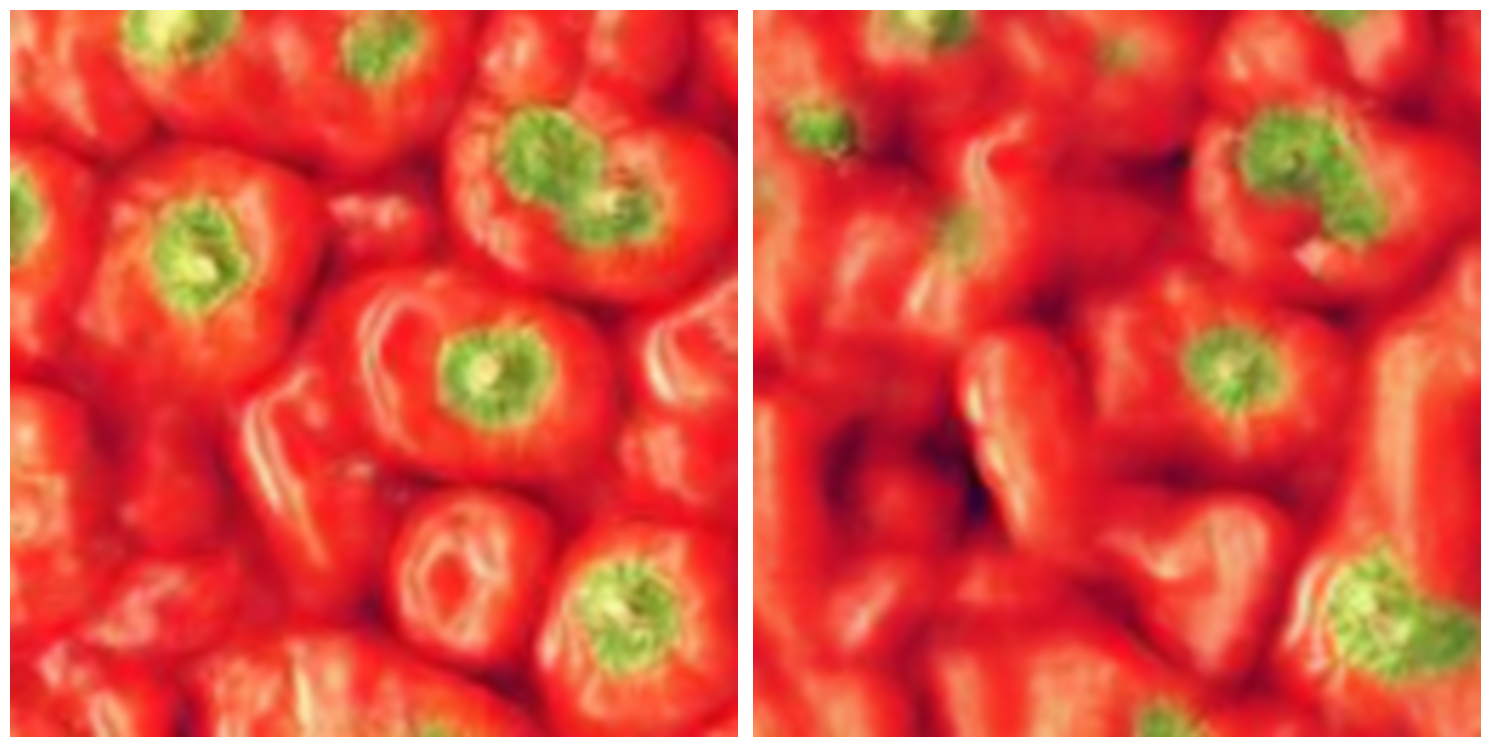

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1211.9913..52.973057].


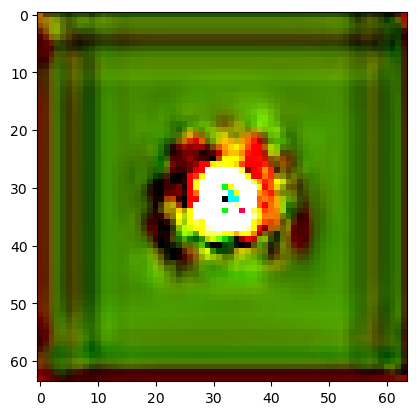

In [ ]:
img_torch = Tensor_load(file_name)[...]
img_torch0 = torch.clone(img_torch)*2-1
mu,sigma=img_torch0.mean(),img_torch0.std()

flow_model = Unet(
    dim =32,
    dim_mults = (1, 2),#, 4),
    mid_fourier=False)

T=15

#flow_model = TimeConditionedUNet(base_channels=128)
if False:
    train_flow_net((img_torch0-mu)/sigma , flow_model,load=False,epochs=10000,save_name='peppers_small_rf')
else:
    flow_model.load_state_dict(torch.load('peppers_small_rf.pth', map_location='cuda'))
flow_model.eval().cuda()
noise_plot=torch.randn(1,3,256,256).cuda()
synth_patch=Diffusion((img_torch0-mu)/sigma,rs=1,T=T,k=10,patchsize=16,stride=4,octaves=1,size=(256,256),renoise=0.5,warmup=0,memory=True,noise=noise_plot,show=False)


with torch.no_grad():
    x = noise_plot*1.
    times_=torch.linspace(0, 1, steps=T+1).cuda()
    for it in range(T):
        t=times_[it]
        t = t.to(device).unsqueeze(0)
        flow = flow_model(x,t.view(1))
        x=x+flow*(times_[it+1]-times_[it])

synth_nn = x*sigma+mu
synth_patch=synth_patch*sigma+mu
synth_nn=synth_nn[...,64:128+64,64:128+64]
synth_patch=synth_patch[...,64:128+64,64:128+64]
Tensor_display(synth_nn, synth_patch)#[...,64:128+64,64:128+64])

imsave('synth_nn_2',synth_nn)
imsave('synth_patch_2',synth_patch)

x0=torch.zeros(1,3,64,64).cuda()
x0[:,:,32,32]=1000
plt.imshow(flow_model(x0,torch.tensor(.5).view(1).cuda())[0].permute(1, 2, 0).detach().cpu().numpy())




# Texture blendig experiments

## Pixel-level blending
At each step, the (normalized) k-NN of the patches in the synthesis are computed separately for the two texture exemplars.\
The velocities are computed independently, and then linearly interpolated with parameter blend_alpha

In [ ]:
imsize = 256 # 128 # 256 # 512 : desired input/output resolution
imsize_out = 256 
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

data_rep = 'textures/'
! ls textures/
im_name  =   'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png

save_rep = 'res/'


file_name = data_rep + 'red_peppers_256.jpg' # 'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
file_name2 = data_rep + 'cordes.png'# 'radishes_256.jpg' # 'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
 
## load image as a Tensor
img_torch = Tensor_load(file_name)[...]#,:64,:64]
#img_torch = F.interpolate(img_torch, size=(imsize, imsize), mode='bicubic') # resize to desired size
print(img_torch.shape)
im1 = Tensor_load(file_name)[...]*2-1
im2 = Tensor_load(file_name2)[...]*2-1

blend_alpha=.6
synth= Nifty(im1,im2,rs=1.,T=50,k=10,patchsize=16,stride=4,octaves=3,size=(256,256),renoise=0.3,warmup=0,memory=True,blend=True,blend_alpha=blend_alpha,show=False) 
imsave('interp_pixel_space_%s_%s_%.1f'%(file_name.split('.')[0].split('/')[-1],file_name2.split('.')[0].split('/')[-1],blend_alpha),synth)


cordes.png	   fabric.jpg  pumkins_512.png	 rafia.jpg	      tiles.png
_DSC0418_2048.jpg  paper.jpg   radishes_256.jpg  red_peppers_256.jpg
torch.Size([1, 3, 256, 256])


## Distribution-level blending
At each step, the (normalized) k-NN are computed over the union of patches from both reference images.\
This leads to texture-homogeneous regions.

In [ ]:
imsize = 256 # 128 # 256 # 512 : desired input/output resolution
imsize_out = 256 
BATCH_SIZE = 1 # should be one, we only want to optimize one image at a time here

data_rep = 'textures/'
! ls textures/
im_name  =   'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png

save_rep = 'res/'


file_name = data_rep + 'red_peppers_256.jpg' # 'cordes.png' #'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
file_name2 = data_rep + 'cordes.png'#'radishes_256.jpg' # 'red_peppers_256.jpg' # cordes_256.png      radishes_256.jpg    red_peppers_256.jpg      pumkins_512.png     rafia.jpg           tiles.png
 
## load image as a Tensor
img_torch = Tensor_load(file_name)[...]#,:64,:64]
#img_torch = F.interpolate(img_torch, size=(imsize, imsize), mode='bicubic') # resize to desired size
print(img_torch.shape)
im1 = Tensor_load(file_name)[...]*2-1
im2 = Tensor_load(file_name2)[...]*2-1

synth= Nifty(im1,im2,rs=1.,T=50,k=10,patchsize=16,stride=4,octaves=3,size=(256,256),renoise=0.5,warmup=0,memory=True,show=False) 
imsave('interp_patch_distribution_%s_%s'%(file_name.split('.')[0].split('/')[-1],file_name2.split('.')[0].split('/')[-1]),synth)


cordes.png	   fabric.jpg  pumkins_512.png	 rafia.jpg	      tiles.png
_DSC0418_2048.jpg  paper.jpg   radishes_256.jpg  red_peppers_256.jpg
torch.Size([1, 3, 256, 256])
